In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

In [3]:
omega_index = 1 # while we debug, we confine our attention to just one value
omnuh2_float = ci.OMNUH2_FLOATS[omega_index]
omnuh2_str = ci.OMNUH2_STRS[omega_index]

In [4]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
powernu3 = ci.load_benchmark(
    "power_nu3/Aletheia_powernu3_zorig_nu",
    ["0.0006", "0.0021", "0.0064", "0.0100"] 
)

In [5]:
ci.OMNUH2_FLOATS = ci.OMNUH2_FLOATS[:(len(ci.OMNUH2_FLOATS) - 1)]
ci.OMNUH2_STRS = ci.OMNUH2_STRS[:(len(ci.OMNUH2_STRS) - 1)]

In [31]:
# It's a waste of time to consider all of the omegas and snapshots,
# so we're making heavy use of skips.
spectra = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
    skips_omega = [], skips_model=[8], skips_snapshot=[1, 2, 3],
    k_points=1000)

012

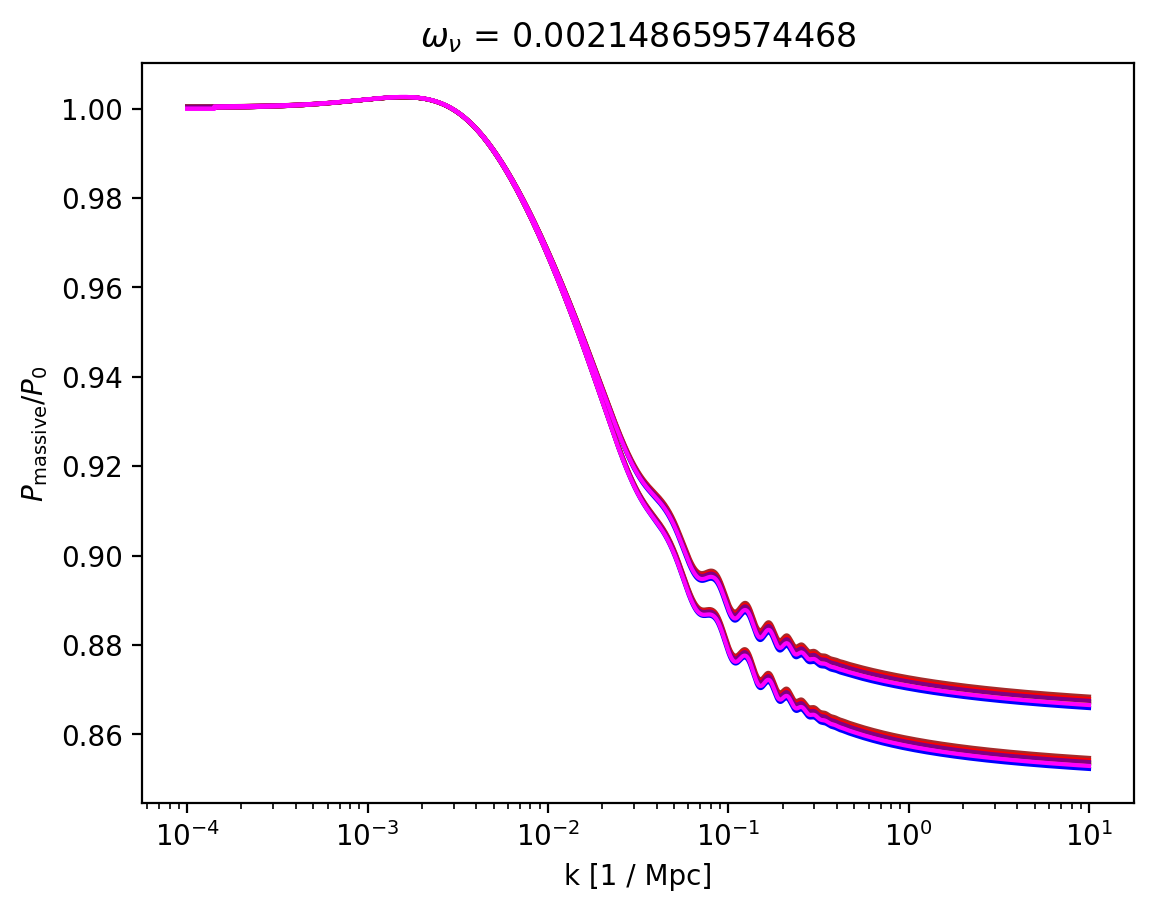

In [7]:
for i in range(len(spectra[omnuh2_float])):
    if spectra[omnuh2_float][i] is None:
        continue
    h = ci.cosm.loc[i]["h"]
    for j in range(len(spectra[omnuh2_float][i])):
        if spectra[omnuh2_float][i][j] is None:
            continue
        plt.plot(spectra[omnuh2_float][i][j]["k"],
            spectra[omnuh2_float][i][j]["P_nu"] / \
            spectra[omnuh2_float][i][j]["P_no"],
            label="model " + str(i) + ", no renormalizing, z=" + \
            str(ci.parse_redshifts(i)[j]), c=ci.colors[i],
            linestyle=ci.styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omnuh2_float))

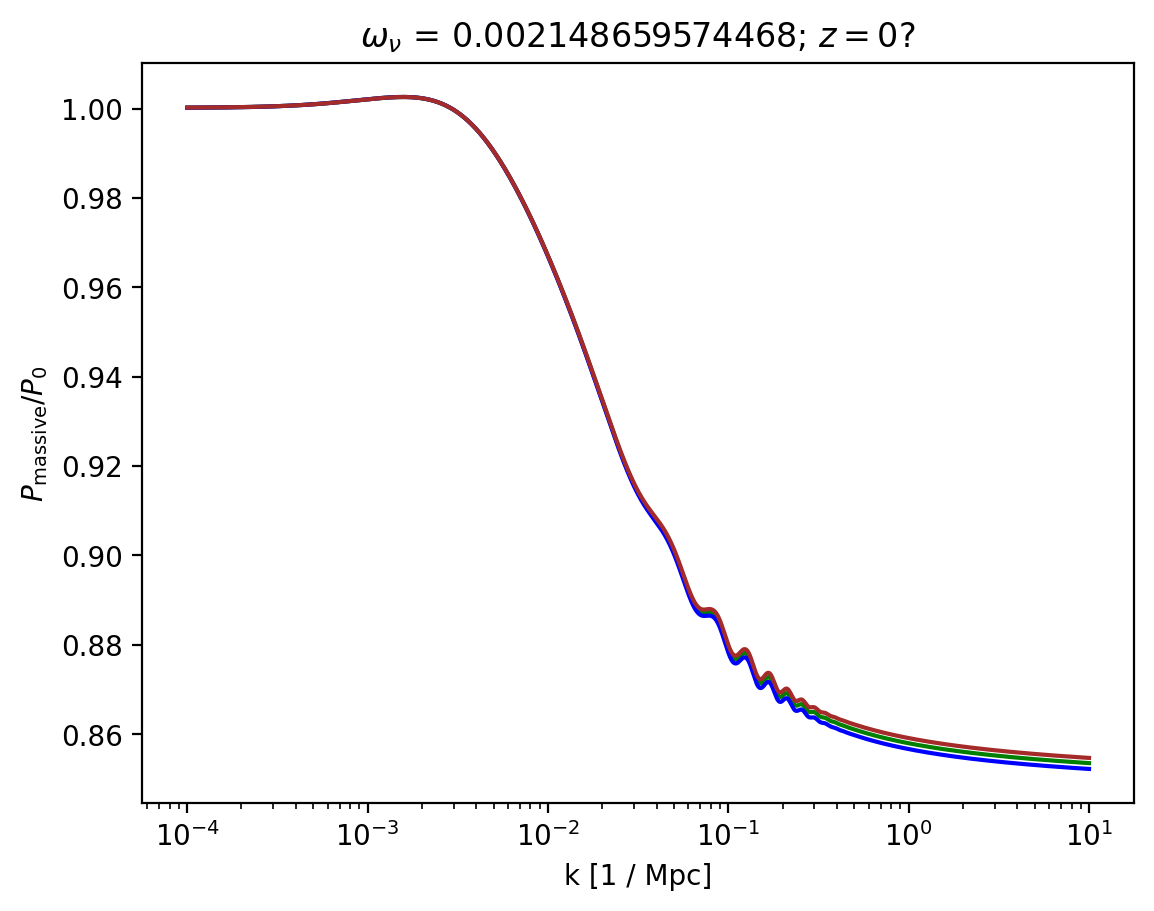

In [8]:
for i in range(0, 3):
    if spectra[omnuh2_float][i] is None:
        continue
    h = ci.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(spectra[omnuh2_float][i][j]["k"],
        spectra[omnuh2_float][i][j]["P_nu"] / \
        spectra[omnuh2_float][i][j]["P_no"],
        label="model " + str(i), c=ci.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omnuh2_float) + "; $z=0$?")

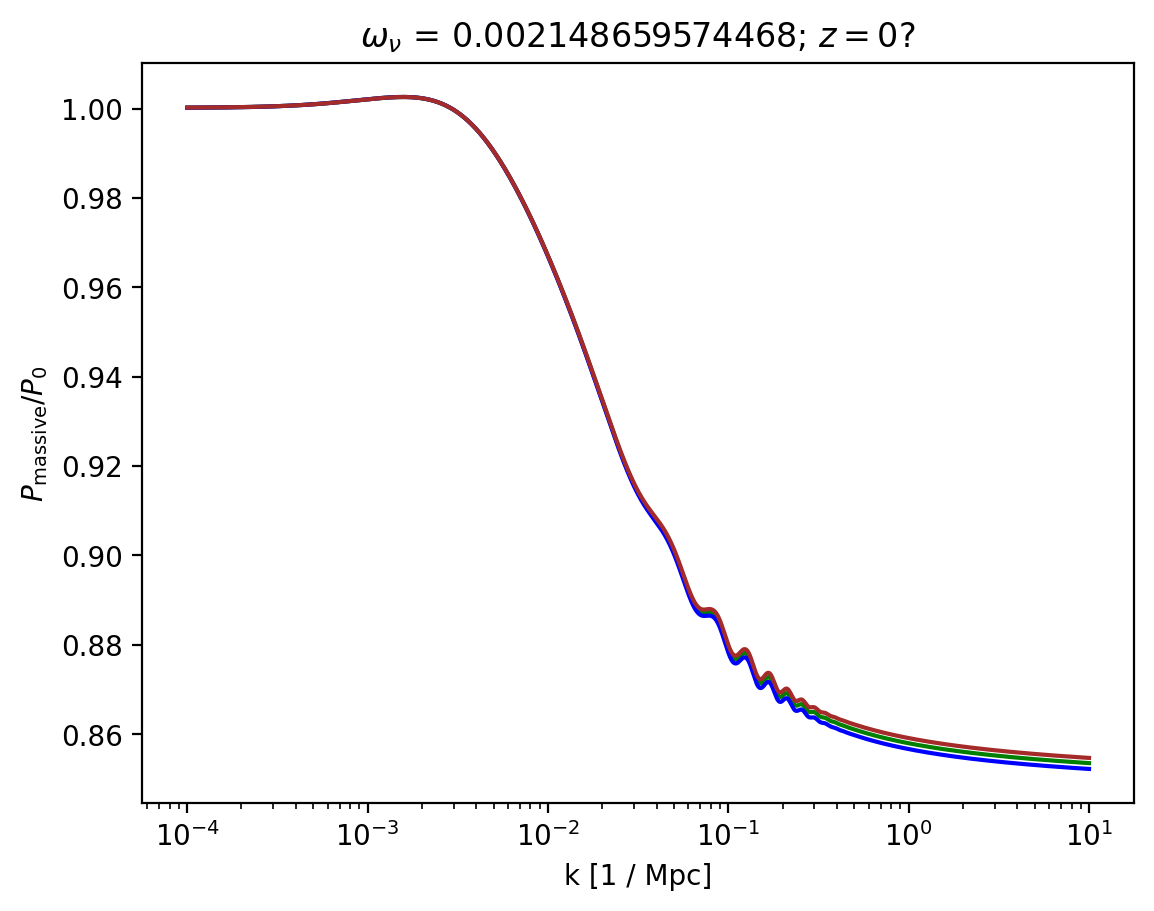

In [9]:
for i in range(0, 3):
    if spectra[omnuh2_float][i] is None:
        continue
    h = ci.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(spectra[omnuh2_float][i][j]["k"],
        spectra[omnuh2_float][i][j]["P_nu"] / \
        spectra[omnuh2_float][i][j]["P_no"],
        label="model " + str(i), c=ci.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omnuh2_float) + "; $z=0$?")

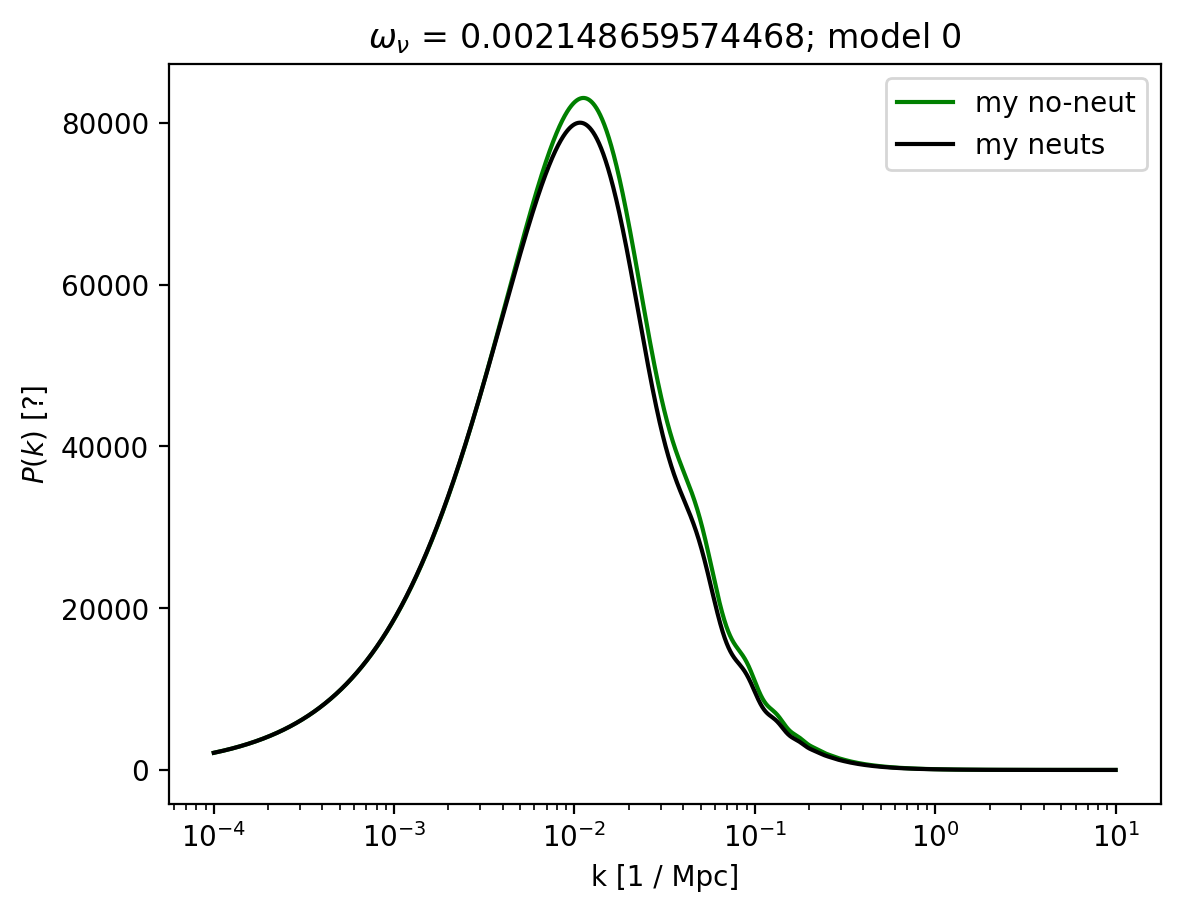

In [10]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 4
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_no"], label="my no-neut", c=ci.colors[i])
plt.plot(spectrum["k"], spectrum["P_nu"], label="my neuts", c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(omnuh2_float) + "; model 0")
plt.legend()

# This protects other cells by avoiding accidental reuse
del i, h, j, spectrum

In [12]:
i = 5
true3_early = powernu3[omnuh2_str][i][0]
true3_late = powernu3[omnuh2_str][i][4]
# The following construction makes indexing a little easier later.
true3 = [true3_early, None, None, None, true3_late]

#LCDM = np.load('../../CAKE21/matteos_spectra/LCDM.npy', allow_pickle=True)[0]
#nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM.npy', allow_pickle=True)[0]

LCDM = np.load('../../CAKE21/matteos_spectra/LCDM_tiny.npy', allow_pickle=True).item()
nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM_tiny.npy', allow_pickle=True).item()

mimsim = np.load('../../CAKE21/matteos_spectra/mimsims.npy', allow_pickle=True).item()

In [13]:
model0 = {
    'ombh2' : 0.022445,
    'omch2' : 0.120567,
    'n_s' : 0.96,
    'A_s' : 2.12723788013000E-09,
    'h' : 0.67,
    'w0' : -1.00,
    'wa' : 0.00,
    'OmK' : 0.00
}          

model0_zs = [
    2.000000,
    1.000000,
    0.570000,
    0.300000,
    0.000000
]

model0_zs_ends = [
    model0_zs[0],
    model0_zs[len(model0_zs) - 1]
]

def model_i_ends(i):
    zs = ci.parse_redshifts(i)
    return [max(zs), min(zs)]

omnu_Lukas = ci.OMNUH2_FLOATS[1]

modeli = 0
model = ci.specify_neutrino_mass(ci.cosm.iloc[modeli], 0, 0)

MEMNeC = ci.specify_neutrino_mass(ci.cosm.iloc[modeli],
    omnu_Lukas, 1)

Lukas_LCDM = ci.evaluate_cosmology(
    model, redshifts=model_i_ends(modeli))
Lukas_nuCDM = ci.evaluate_cosmology(
    MEMNeC, redshifts=model_i_ends(modeli))
Lukas_h = ci.cosm.iloc[modeli]['h']

[2.   1.   0.57 0.3  0.  ]


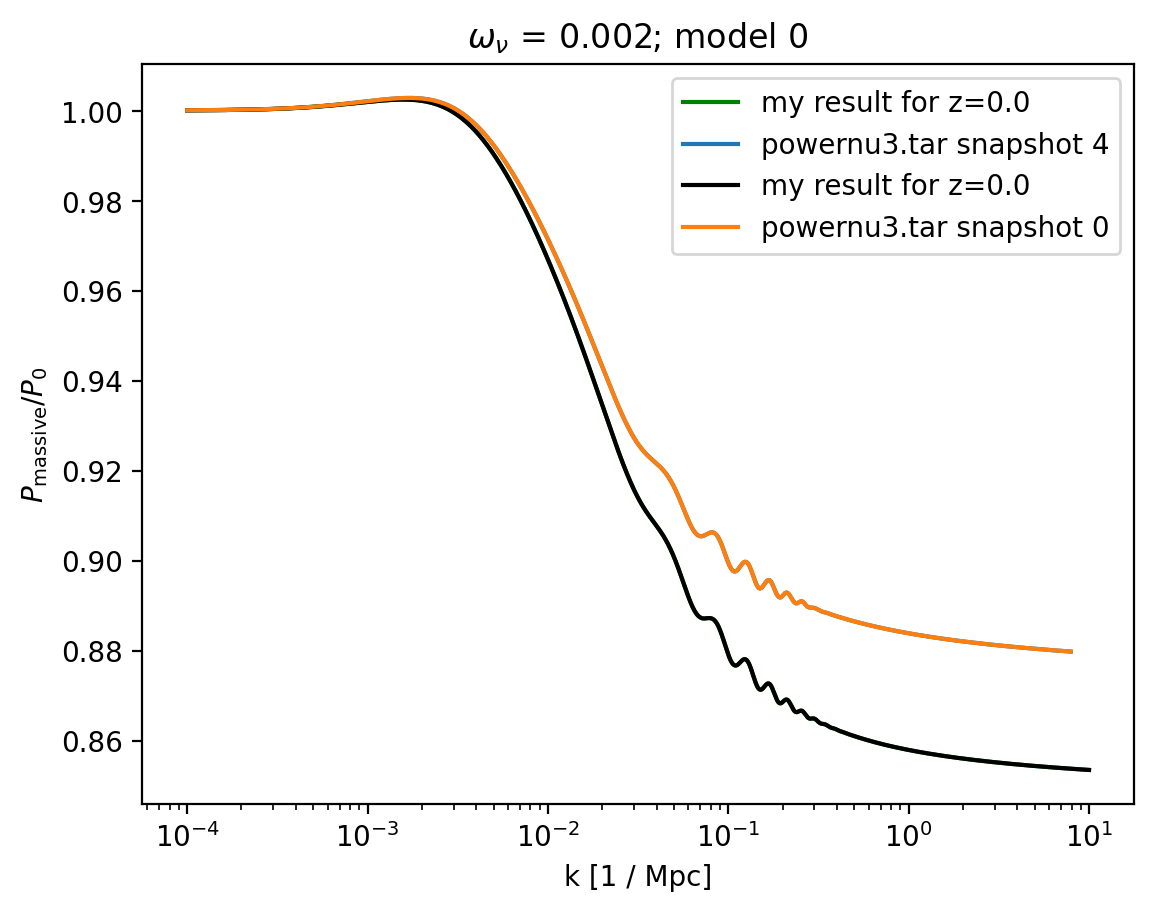

In [14]:
# best case seems to be i = 0
# worst case seems to be i = 1
i=0
on_accessor = ci.OMNUH2_FLOATS[1]
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)

print(z_list)
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c=ci.colors[i],
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 4")
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c="black",
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del h, j, z_list, spectrum, on_accessor

[2.   1.   0.57 0.3  0.  ]


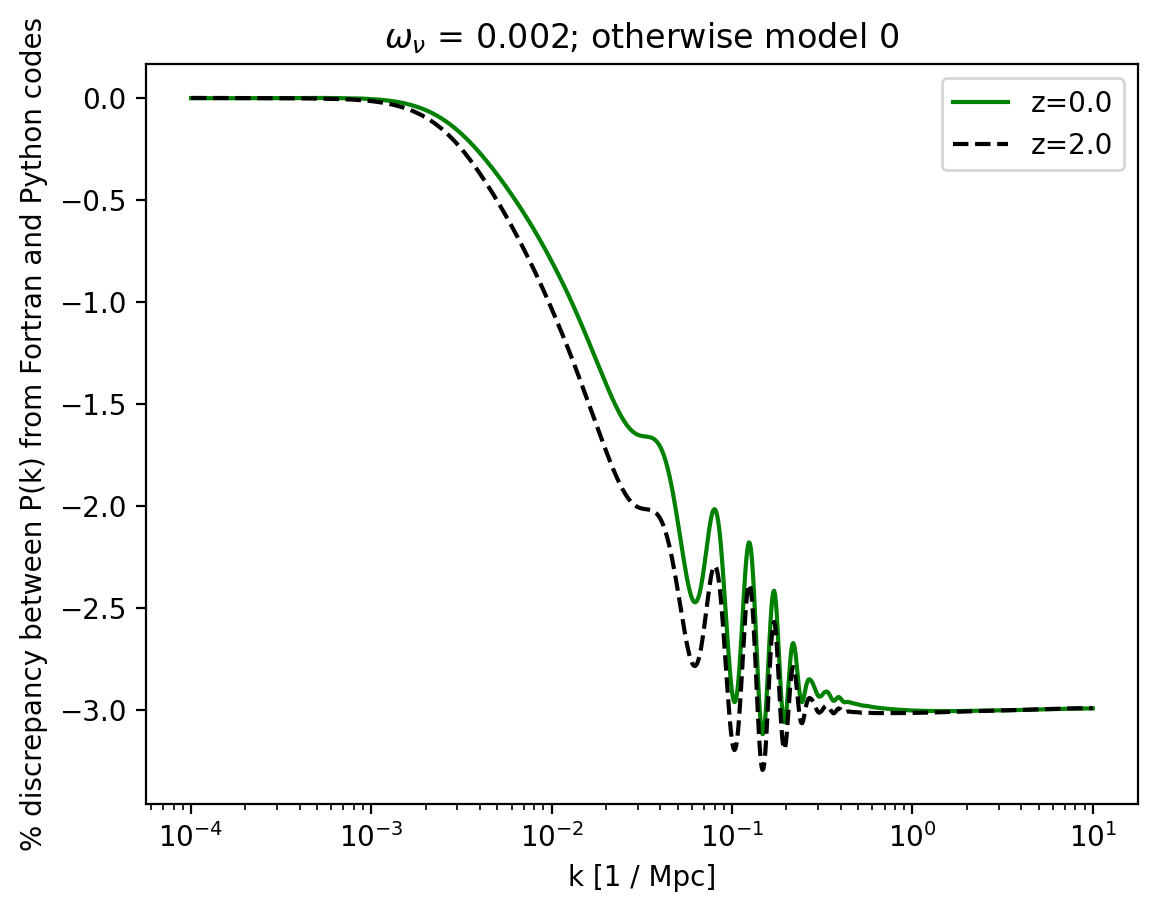

In [38]:
# best case seems to be i = 0
# worst case seems to be i = 1
i=0
on_accessor = ci.OMNUH2_FLOATS[1]
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)

print(z_list)

spectrum = spectra[on_accessor][i][j]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[j]["ratio"]
error = (x_Lukas - x_Ariel) / x_Ariel * 100

plt.plot(spectrum["k"], error, c=ci.colors[i],
    label="z=" + str(z_list[j]))

j = 0
spectrum = spectra[on_accessor][i][j]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[j]["ratio"]
error = (x_Lukas - x_Ariel) / x_Ariel * 100

plt.plot(spectrum["k"], error, c="black",
    label="z=" + str(z_list[j]),
    linestyle="dashed")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; otherwise model 0")
plt.legend()

plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del h, j, z_list, spectrum, on_accessor

[2.   1.   0.57 0.3  0.  ]


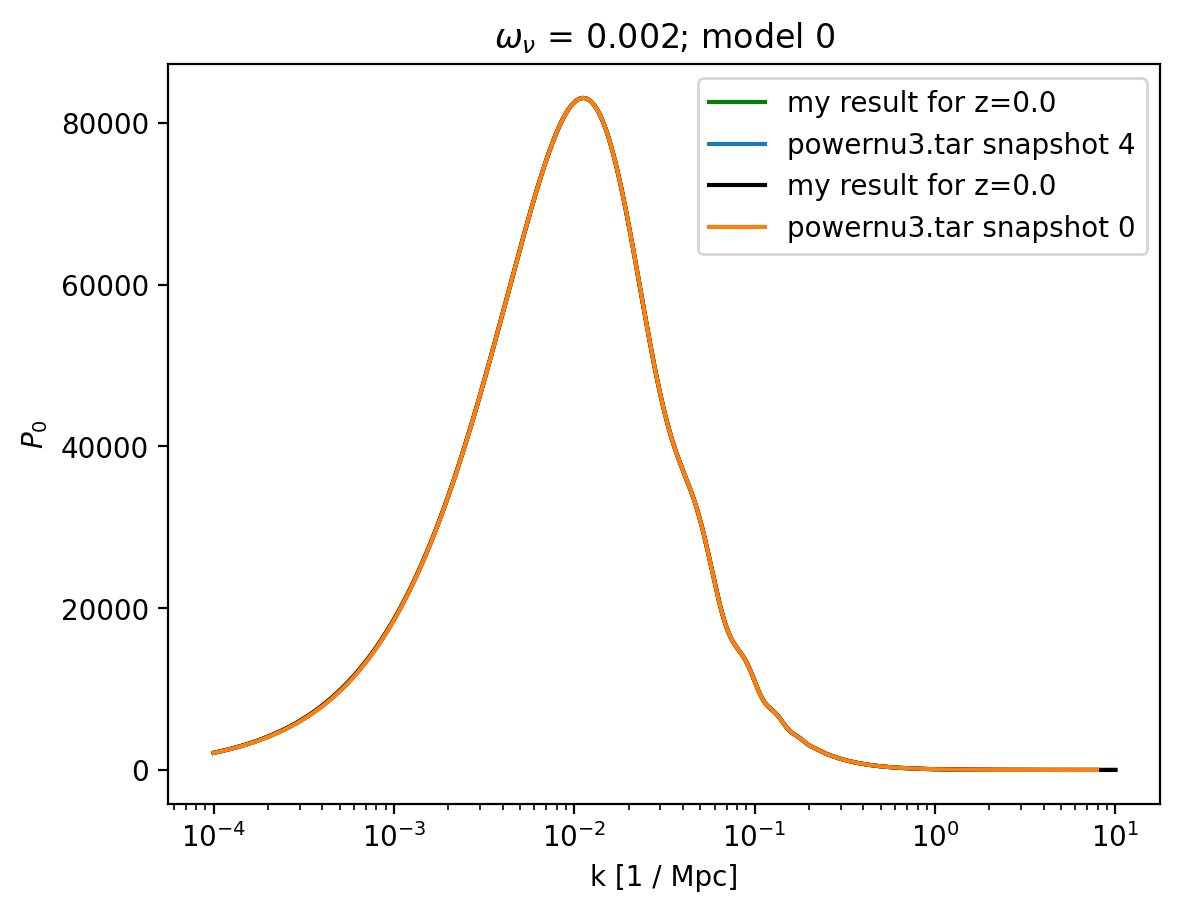

In [29]:
# best case seems to be i = 0
# worst case seems to be i = 1
i=0
on_accessor = ci.OMNUH2_FLOATS[1]
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)

print(z_list)
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_no"], c=ci.colors[i],
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["P_no"],
         label="powernu3.tar snapshot 4")
spectrum = spectra[on_accessor][i][j]

plt.plot(spectrum["k"], spectrum["P_no"], c="black",
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["P_no"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

In [30]:
print(spectrum["k"].shape)
print(true3[j]["k"].shape)

(100000,)
(1000,)


In [ ]:
# This protects other cells by avoiding unintended reuse
del h, j, z_list, spectrum, on_accessor

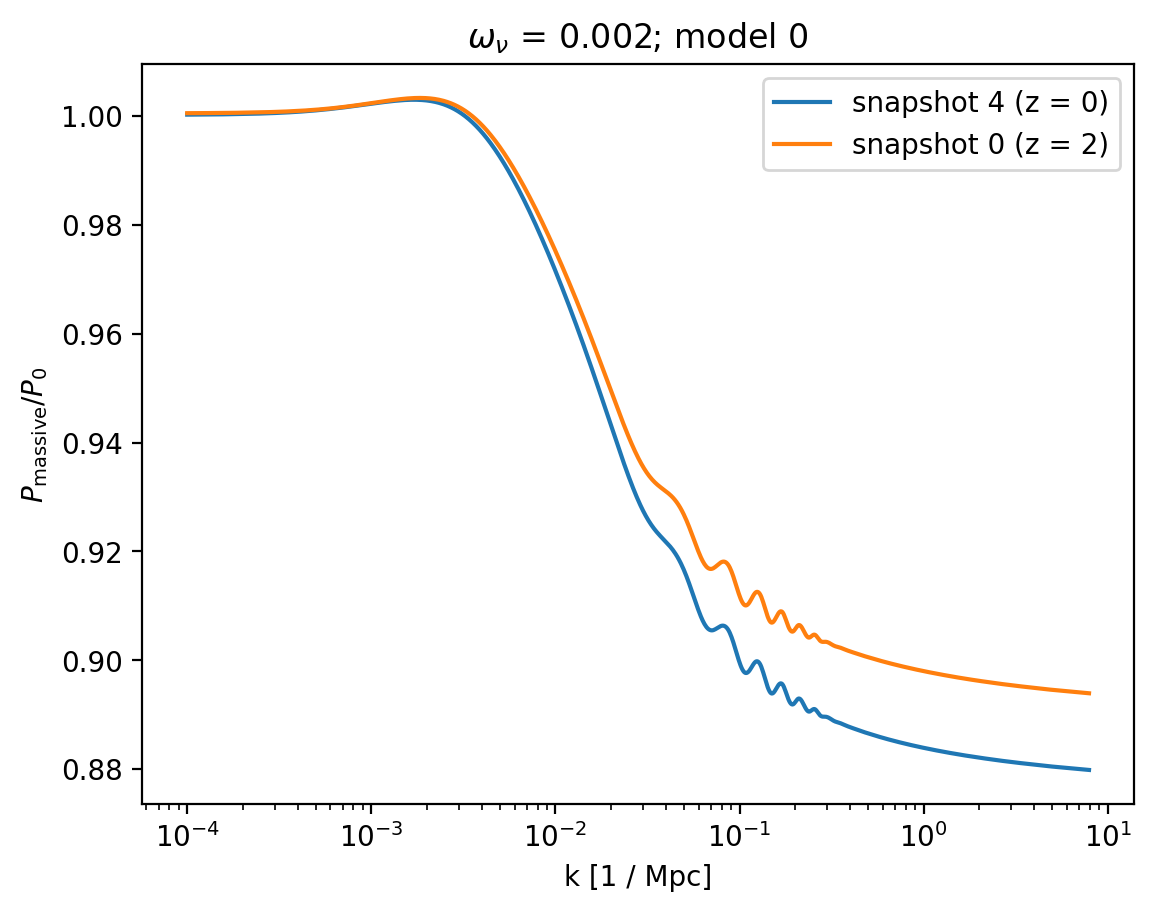

In [17]:
# best case seems to be i = 0
# worst case seems to be i = 1
del i
on_accessor = ci.OMNUH2_FLOATS[1]
i = 1
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[on_accessor][i][j]

plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="snapshot 4 (z = 0)")
#plt.plot(Lukas_LCDM[0] * model0['h'], Lukas_nuCDM[2][1] / Lukas_LCDM[2][1],
#             label='Lukas direct snap 4'.format(0))
#plt.plot(LCDM['kk'], nuCDM['Pk'][4] / LCDM['Pk'][4],
#             label='Matteo, snapshot 4?'.format(0))

j = 0 # This will correspond to z=0 for the model0 case.
spectrum = spectra[on_accessor][i][j]

plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="snapshot 0 (z = 2)")
#plt.plot(Lukas_LCDM[0] * model0['h'], Lukas_nuCDM[2][0] / Lukas_LCDM[2][0],
#             label='Lukas direct snap 0'.format(0))
#plt.plot(LCDM['kk'], nuCDM['Pk'][0] / LCDM['Pk'][0],
#             label='Matteo, snapshot 0?'.format(0))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum, on_accessor

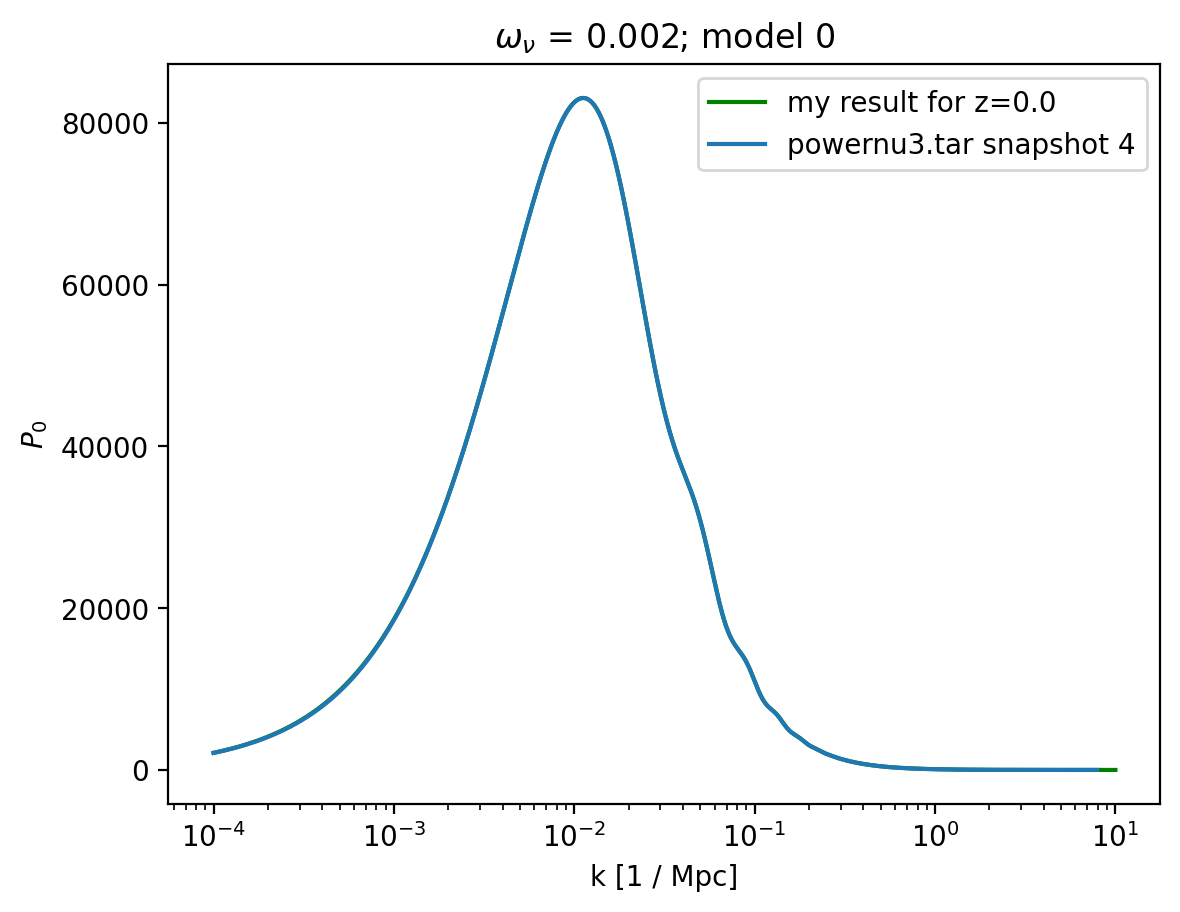

In [18]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_no"], c=ci.colors[i],
    label="my result for z=" + str(spectrum["z"]))
plt.plot(true3_late["k"], true3_late["P_no"],
         label="powernu3.tar snapshot 4")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum

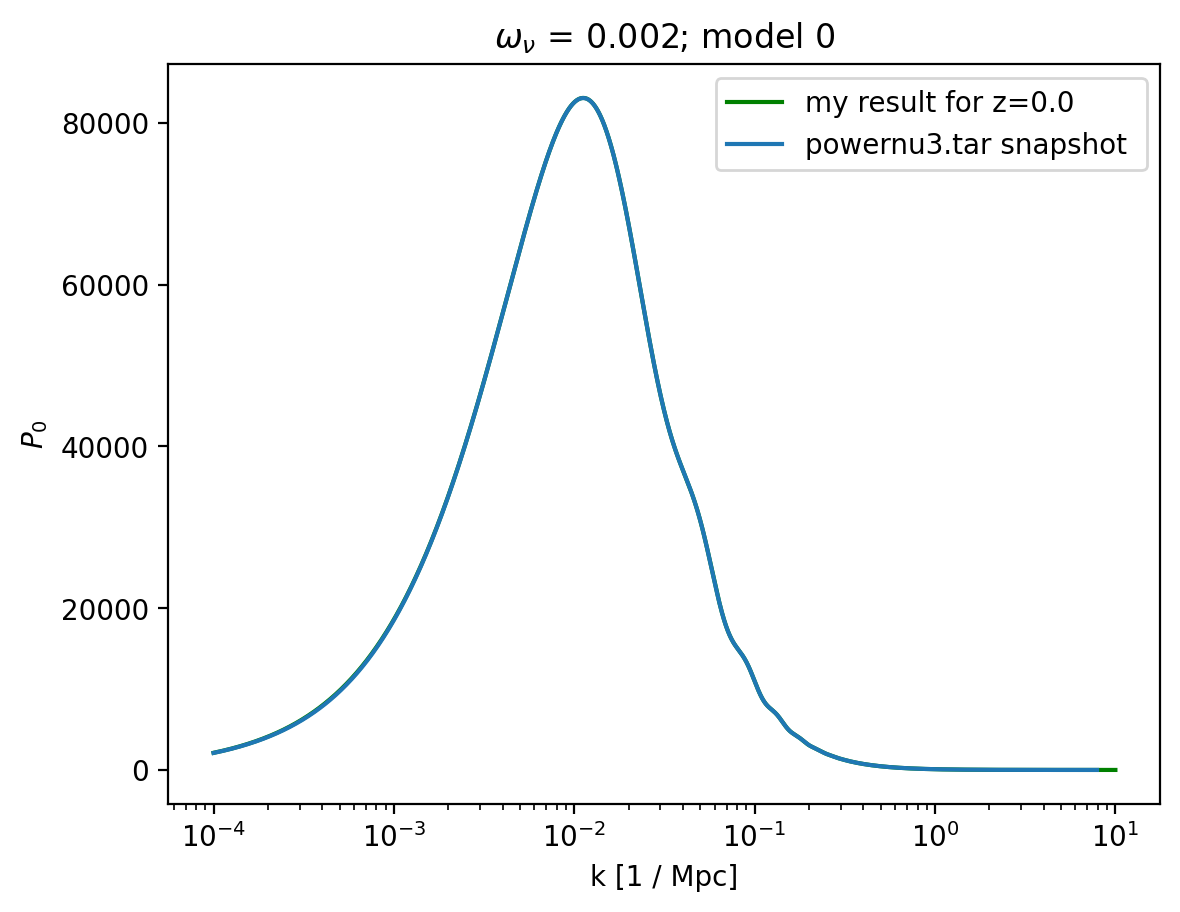

In [19]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_no"], c=ci.colors[i],
    label="my result for z=" + str(spectrum["z"]))
plt.plot(true3_late["k"], true3_late["P_no"],
         label="powernu3.tar snapshot ")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum

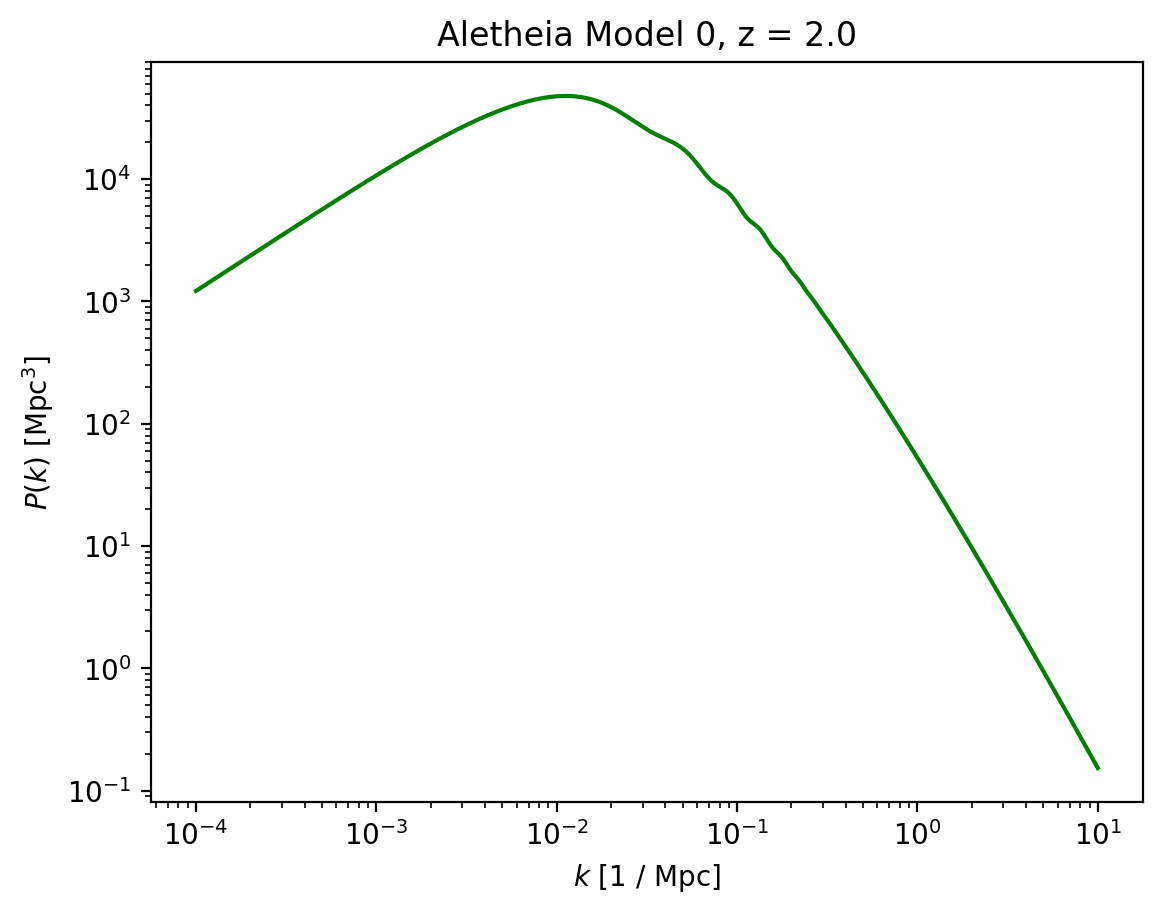

In [20]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 0 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_no"] / 0.67 ** 3, c=ci.colors[i])

plt.xscale('log')
plt.xlabel(r"$k$ [1 / Mpc]")
plt.ylabel(r"$P(k)$ [Mpc$^3$]")
plt.yscale('log')
plt.title(r"Aletheia Model 0, z = 2.0")
#plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum

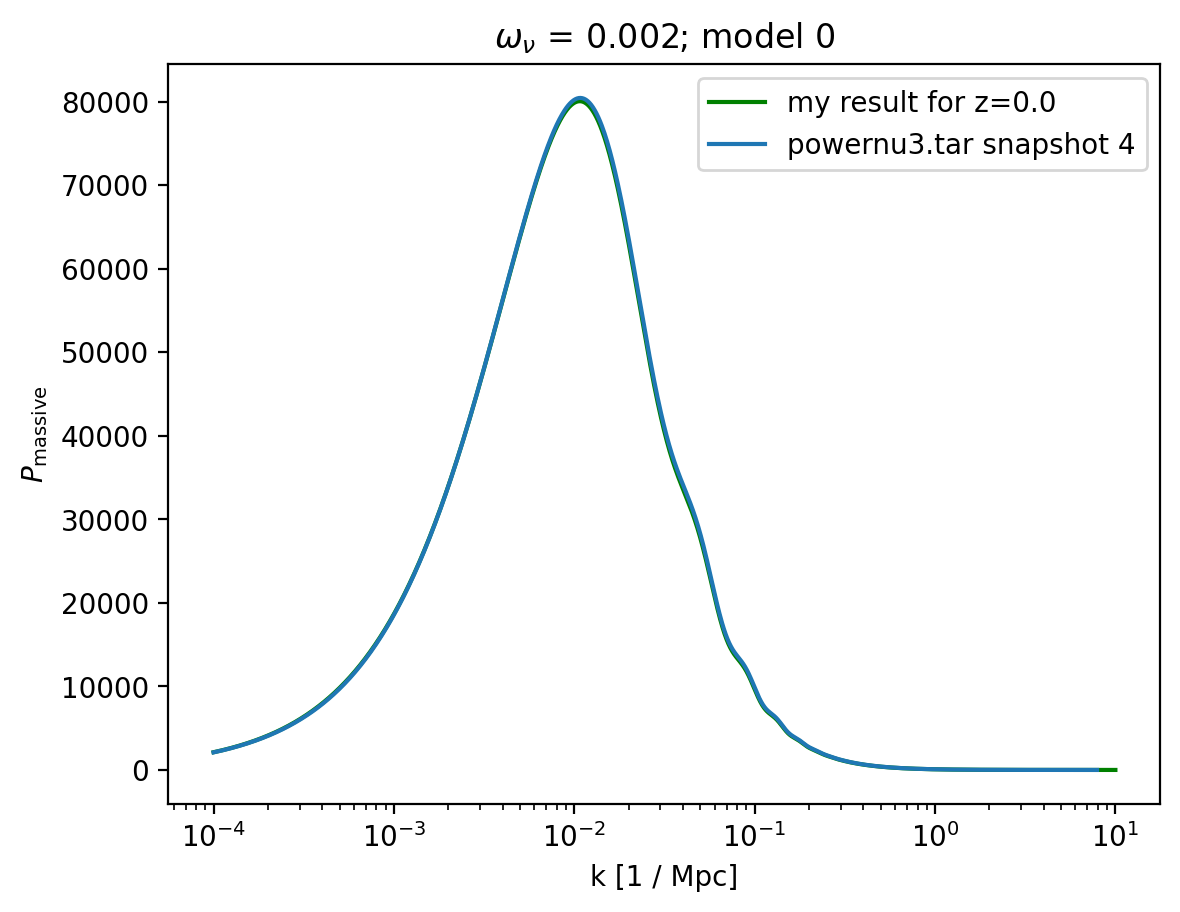

In [21]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"], c=ci.colors[i],
    label="my result for z=" + str(spectrum["z"]))
plt.plot(true3_late["k"], true3_late["P_nu"],
         label="powernu3.tar snapshot 4")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive}$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum

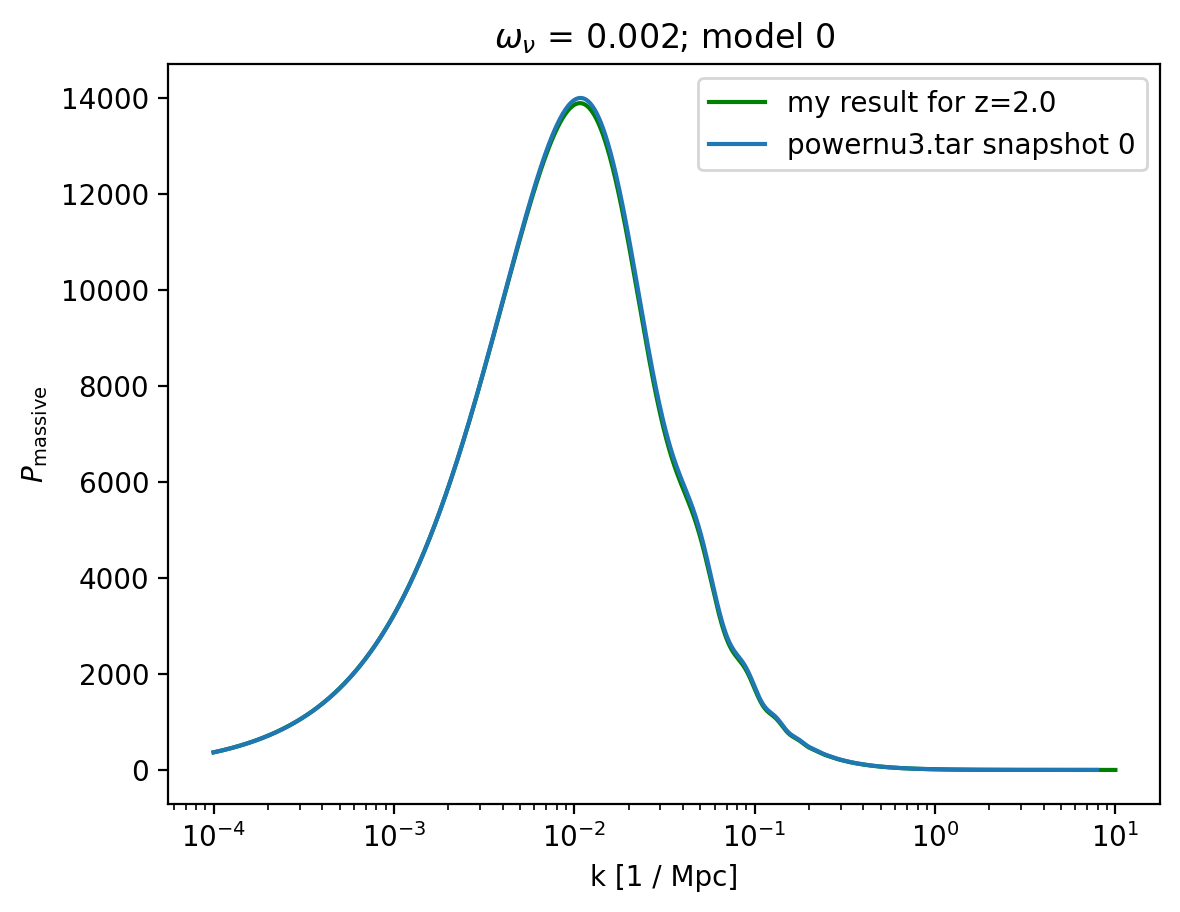

In [22]:
i = 0
h = ci.cosm.loc[i]["h"]
j = 0 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(i)
spectrum = spectra[omnuh2_float][i][j]

plt.plot(spectrum["k"], spectrum["P_nu"], c=ci.colors[i],
    label="my result for z=" + str(spectrum["z"]))
plt.plot(true3_early["k"], true3_early["P_nu"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive}$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, spectrum